# Scalable ML: Algorithms for Ridge Regression

Here will experiment with various algorithms for solving a regularized least square regression problem (ridge regression), and analyze the speed of convergence. Ridge regression is a supervised problem that receives a dataset $x_1,\dots,x_N \in \mathbb{R}^d$ and corresponding labels $t_1,\dots,t_N \in \mathbb{R}$, and finds the weight parameter $w \in \mathbb{R}^d$ that optimizes:
$$
\min_w J(w) \qquad \text{where} \qquad J(w) = \sum_{i=1}^N (x_i^\top w - t_i)^2 + \lambda \|w\|^2
$$
The objective can also be expressed in vector form as:
$$
J(w) = \|X^\top w - t\|^2 + \lambda \|w\|^2
$$
where we have defined the matrix
$$
X = \Big[x_1 \Big| \dots \Big| x_N \Big]
$$
of size $d \times N$, and the vector
$$
\qquad t = [t_1 , \dots , t_N]
$$
of size $N$. Given a dataset $(X,t)$, and the ridge parameter $\lambda$, the objective function at a given parameter value $w$ can be computed with the code

In [1]:
import numpy

def obj(X,T,w,l):
    d,N = X.shape
    return ((numpy.dot(X.T,w)-T)**2).sum() + l*(w**2).sum()

where `l` denotes the parameter $\lambda$. A first approach to optimize this objective is gradient descent. The derivative of this objective is given as
\begin{align*}
\nabla J(w)
&= 2 \sum_{i=1}^N x_i (x_i^\top w - t_i) + 2 \lambda w\\
&= 2 X (X^\top w - t) + 2 \lambda w\\
\end{align*}
A gradient descent optimization procedure can be written in pseudo-code as:

    w = 0
    while True:
        w = w - gamma * dJ(w)

Because the objective function is convex and differentiable, the gradient descent will (for sufficiently small learning rate) always converge to the true solution. The code for gradient descent is provided below:

In [2]:
import time

cpt = [0]+list(map(int,numpy.logspace(0,5,50)))

maxsteps = 100000
# ----------------------------------------------------
# Gradient descent
#  X:     input matrix
#  T:     label vector
#  l:     ridge parameter
#  gamma: learning rate
# ----------------------------------------------------

def gd(X,T,l,gamma):

    # Initialize the procedure
    d,N = X.shape
    start = time.clock()
    wlist,tlist = [],[]
    
    # Initialize the parameter at some reasonable value
    w = numpy.zeros(d)
    
    # Perform multiple steps of gradient descent
    for it in range(maxsteps):

        if it in cpt:
            wlist += [w]
            tlist += [time.clock()-start]
        
        # Perform one step of gradient descent
        E = numpy.dot(X.T,w)-T
        w = w - gamma*(2.0*numpy.dot(X,E) + 2.0*l*w)
    
        # Stop training after 0.25 seconds elapsed
        if tlist[-1]>0.25: break
    
    # Return a sequence of parameters and the corresponding time to reach them
    return wlist,tlist

In addition to the core gradient descent code, the code has been instrumented with various functionalities that will be useful for benchmarking against other implementations. The procedure returns a sequence of parameters `wlist`, and the list of associated computation times `tlist`.

We will now implement three different optimization procedure. The first one is a simple variant of gradient descent, but where some quantities are precomputed and can be reused during training. The second procedure evaluates a closed-form solution of the problem. The last one, known as stochastic gradient descent, optimizes a fast stochastic approximation of the objective.

### 1.Gradient descent with pre-computations

When evaluating the gradient of the objective $J(\theta)$, the order of matrix multiplications matters in terms of speed of computation. Also, if the gradient of the objective is rewritten from
\begin{align*}
\nabla J(w) &= 2 X (X^\top w - t) + 2 \lambda w
\end{align*}
to
\begin{align*}
\nabla J(w) &= 2 \underbrace{(X X^\top)}_{S} w - 2 \underbrace{X t}_{q} + 2 \lambda w
\end{align*}
i.e. we reverse the order of computations, part of the computation ($S$ and $q$) no longer depends on $w$ and can therefore be evaluated before the gradient descent start.


* **We create a method inspired from the method `gd` above, that implements the proposed pre-computations.**

In [3]:
import numpy as np

def gdprecomp(X,T,l,gamma):
    
    # init
    
    d,N = X.shape
    start = time.clock()
    wlist,tlist = [],[]
    
    # precompile S and q
    S = numpy.dot(X,X.T)#X @ X.T
    q = numpy.dot(X,T)#X @ T
    
    w = numpy.zeros(d)
    
    # Perform multiple steps of gradient descent
    for it in range(maxsteps):

        if it in cpt:
            wlist += [w]
            tlist += [time.clock()-start]
        
        # Perform one step of gradient descent
        #w = w - gamma*(2*S@w - 2*q + 2.0*l*w)
        w = w - gamma*(2*numpy.dot(S,w) - 2*q + 2.0*l*w)
    
        # Stop training after 0.25 seconds elapsed
        if tlist[-1]>0.25: break
        
    return wlist,tlist

### 2. Closed-form solution

A closed-form solution to the problem is obtained by posing directly $\nabla J(w) = 0$ and solving the equation for $w$. This leads to the solution:
\begin{align*}
w = (X X^\top + \lambda I)^{-1} X t
\end{align*}
Because this solution requires a matrix inversion or solving a linear system, it can be computationally expensive. However, this solution is exact and can serve as a ground truth to evaluate the convergence of other training algorithms.


* **We create a method that performs this closed-form evaluation. Unlike other optimization methods, here, only a single parameter and time estimate should be returned.**

In [4]:
def closedform(X,T,l):

    start = time.clock()
    d,N = X.shape
    
    A = numpy.dot(X,X.T) + l*np.eye(d)
    
    w = np.linalg.solve(A,np.dot(X,T))
    t = time.clock()-start
    
    return w,t

### 3. Stochastic gradient descent

The objective $J(\theta)$ and its gradient can be long to compute due to the summation over a potentially large number of examples. An unbiased estimator of the true gradient is given by:
\begin{align*}
\hat \nabla J(\theta) = 2 N x_i (x_i^\top w - t_i) + 2 \lambda w \qquad i \sim \text{random}(1,N).
\end{align*}
The variable $i$ is a random integer between $1$ and $N$. The optimization procedure can therefore be written in pseudo-code as:

    w = 0
    for t in range(100000):
        i ~ random(1,N)
        w = w - gamma(t) * dJ(w,i)
        
As the gradient is subject to random noise, the learning rate $\gamma$ must be chosen carefully to ensure convergence. The choice $\gamma(t) = \gamma_0 \cdot (1+t)^{-0.5}$ makes training fast but also guarantees convergence when $t \to \infty$.


* **We create a method that implements stochastic gradient descent.**

In [5]:
def sgd(X,T,l,gamma0):
    
    # Initialize the procedure
    d,N = X.shape
    numpy.random.seed(1234)
    start = time.clock()
    wlist,tlist = [],[]
    
    # Initialize the parameter at some reasonable value
    w = numpy.zeros(d)
    
    # Perform multiple steps of gradient descent
    for it in range(maxsteps):        
        if it in cpt:
            wlist += [w]
            tlist += [time.clock()-start]
            
        i = np.random.randint(N)
        x_i = X[:,i]
        gamma_t = gamma0*np.power(1+it,-.5)
        e = numpy.dot(x_i,w)-T[i]
        w = w - gamma_t * (2*N*x_i*e+2*l*w)
        
        # Stop training after 0.25 seconds elapsed
        if tlist[-1]>0.25: break
        
    return wlist,tlist

### 4. Analysis

The following code tests the behavior of the different optimization techniques for two different choices of dataset dimensions.

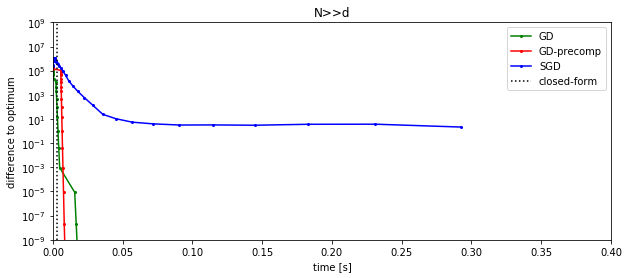

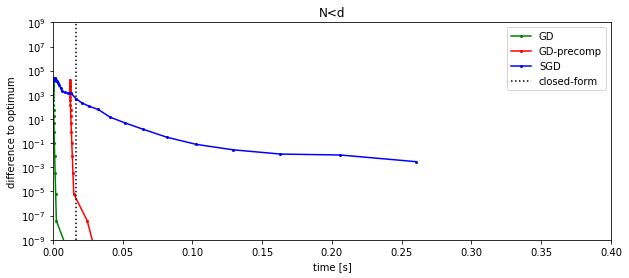

In [6]:
# ----------------------------------------------------
# Benchmarking procedure
#
#  data:  arrays containing input and labels
#  l:     ridge regression parameter
#  title: title of the plot
# ----------------------------------------------------

import utils, matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

def benchmark(data,l,title):

    X,T = data
    
    # Learning rate (chosen heurstically)
    gamma = 0.001 / X.shape[1]**.5

    # Use closed-form computation as optimum
    wopt,t = closedform(X,T,l)
        
    # Apply various iterative procedures for optimization
    ws1,ts1 = gd(X,T,l,gamma)
    ws2,ts2 = gdprecomp(X,T,l,gamma)
    ws3,ts3 = sgd(X,T,l,gamma)
    
    # Compare how different from the optimum we are
    es1 = ([obj(X,T,w,l) - obj(X,T,wopt,l) for w in ws1])
    es2 = ([obj(X,T,w,l) - obj(X,T,wopt,l) for w in ws2])
    es3 = ([obj(X,T,w,l) - obj(X,T,wopt,l) for w in ws3])

    # Plot the convergence curves of the different methods
    plt.figure(figsize=(10,4))
    plt.title(title)
    plt.yscale('log')
    plt.plot(ts1,es1,'o-',color='green',ms=2,label='GD')
    plt.plot(ts2,es2,'o-',color='red',ms=2,label='GD-precomp')
    plt.plot(ts3,es3,'o-',color='blue',ms=2,label='SGD')
    plt.plot([t,t],[1e-9,1e9],'-',ls='dotted',color='black',label='closed-form')
    plt.ylim([1e-9,1e9])
    plt.xlim([0,0.4])
    plt.xlabel('time [s]')
    plt.ylabel('difference to optimum')
    plt.legend().get_frame().set_facecolor('white')

    #print(f'closedform t={t} fuer {title}.' )    
    #print(ts1[10],ts2[10],ts3[10])
    
# Run the benchmark for two datasets with different dimensions

benchmark(utils.getdata(5000,50),1,'N>>d')
benchmark(utils.getdata(50,500),1,'N<d')

**Why does SGD only outperform GD when $N \gg d$ ?**

For $N \gg d$ it is more likely to draw an $i$ where there is a ('good') improvement. Additionally, the upspeed by just taking $x_i$ in contrast to $X$ is way higher for $N \gg d$. So, the computational savings have more impact.

**Why does the SGD error slightly increase before decreasing?**

This could be due to 'bad' luck with $i \sim \text{random}(1,N)$, i.e. bad directions are chosen. So it can happen that a direction can increase the error.

**Why is the closed form drastically slower to compute for $N < d$ than for $N \gg d$?**

For bigger $N$, the matrix $X X^\top + \lambda I$ has a way better condition number and results in a better (and faster) solvability. The speed up comes from the faster convergence of iterative methods for lower condition numbers.

**Why is GD-precomp systematically outperformed by other methods in the early stage of optimization?**

Because the precomputation takes some time and the gain in each iteration is only small (e.g. compared to GD). So it takes some time to sum up.

**When $N < d$, why does GD-precomp converge slower than GD in the final stage, even though it potentially benefits from precomputations?**

The matrix dimensions are so small, that there is probably no real gain but the computation in GD-precomp is most likely numerically worse. Thus, it converges slower (despite being "equivalent").

====================================================

We changed the benchmark in the following a little bit, since we had sometimes odd results. Those are most likely artifacts from the CPU/OS (e.g. branch prediction, boosting \["turbo boost"\], scheduling, switching cores, etc.). So we've run the code multiple times beforehand and used just the last run. In practice this results in faster computations but there are still some artifacts (some steps require higher time). Somehow sometimes GD takes longer to initialize than GD-precomp but in general everything looks more like it does in the sheet. :)

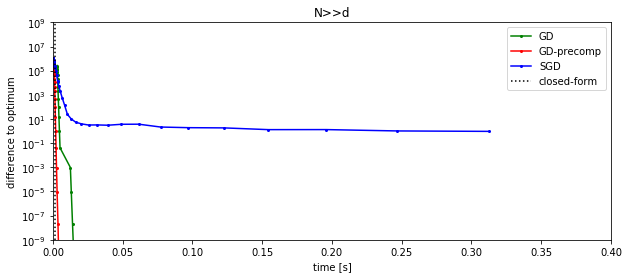

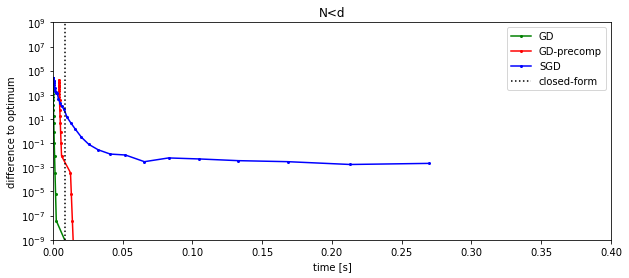

In [7]:
# ----------------------------------------------------
# Benchmarking procedure
#
#  data:  arrays containing input and labels
#  l:     ridge regression parameter
#  title: title of the plot
# ----------------------------------------------------

import utils, matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

def benchmark(data,l,title):

    X,T = data
    
    # Learning rate (chosen heurstically)
    gamma = 0.001 / X.shape[1]**.5

    # Use closed-form computation as optimum
    
    closedform(X,T,l)    
    closedform(X,T,l)    
    closedform(X,T,l)
    wopt,t = closedform(X,T,l)
    # Apply various iterative procedures for optimization  
    
    gd(X,T,l,gamma)
    gd(X,T,l,gamma)
    gd(X,T,l,gamma)
    ws1,ts1 = gd(X,T,l,gamma)
    
    gdprecomp(X,T,l,gamma)
    gdprecomp(X,T,l,gamma)
    gdprecomp(X,T,l,gamma)
    ws2,ts2 = gdprecomp(X,T,l,gamma)
    
    sgd(X,T,l,gamma)
    sgd(X,T,l,gamma)
    sgd(X,T,l,gamma)
    ws3,ts3 = sgd(X,T,l,gamma)
    
    # Compare how different from the optimum we are
    es1 = ([obj(X,T,w,l) - obj(X,T,wopt,l) for w in ws1])
    es2 = ([obj(X,T,w,l) - obj(X,T,wopt,l) for w in ws2])
    es3 = ([obj(X,T,w,l) - obj(X,T,wopt,l) for w in ws3])

    # Plot the convergence curves of the different methods
    plt.figure(figsize=(10,4))
    plt.title(title)
    plt.yscale('log')
    plt.plot(ts1,es1,'o-',color='green',ms=2,label='GD')
    plt.plot(ts2,es2,'o-',color='red',ms=2,label='GD-precomp')
    plt.plot(ts3,es3,'o-',color='blue',ms=2,label='SGD')
    plt.plot([t,t],[1e-9,1e9],'-',ls='dotted',color='black',label='closed-form')
    plt.ylim([1e-9,1e9])
    plt.xlim([0,0.4])
    plt.xlabel('time [s]')
    plt.ylabel('difference to optimum')
    plt.legend().get_frame().set_facecolor('white')

    #print(f'closedform t={t} fuer {title}.' )
    #print(ts1[10],ts2[10],ts3[10])

# Run the benchmark for two datasets with different dimensions

benchmark(utils.getdata(5000,50),1,'N>>d')
benchmark(utils.getdata(50,500),1,'N<d')